## This notebook is an example for LSTM & BiLSTM.
You can find the related paper in the following link: https://www.sciencedirect.com/science/article/abs/pii/S0167278919305974


This model is suitable for dealing with time series problems by using time as the **index**.


In [ ]:
import torch
import numpy as np
import pandas as pd 
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
import random 
import os 
import torch.optim as optim
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import textwrap
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Parameter dictionary
args = {
    "corpusFile": "./ground_pm25.csv",  # Data file path
    "gpu": 0,  # GPU device ID
    "epochs": 100,  # Number of training epochs
    "layers": 2,  # Number of LSTM layers
    "input_size": 9,  # Dimension of input features
    "hidden_size": 32,  # Dimension of hidden layers
    "lr": 0.0001,  # Learning rate
    "sequence_length": 24,  # Length of input sequence
    "batch_size": 64,  # Batch size
    "useGPU": True,  # Whether to use GPU
    "batch_first": True,  # Whether batch_size is the first dimension
    "dropout": 0.005,  # Dropout rate
    "model_name": "LSTM_Model",  # Model name
}

# Add dynamically generated save path
args["save_file"] = f"./model/{args['model_name'].lower()}.pth"

# Select device (GPU or CPU)
device = torch.device(f"cuda:{args['gpu']}" if torch.cuda.is_available() and args["useGPU"] else "cpu")
args["device"] = device

# Print parameters for verification
print("Configuration Parameters:")
for k, v in args.items():
    print(f"{k}: {v}")





Configuration Parameters:
corpusFile: ./ground_pm25.csv
gpu: 0
epochs: 100
layers: 2
input_size: 9
hidden_size: 32
lr: 0.0001
sequence_length: 24
batch_size: 64
useGPU: True
batch_first: True
dropout: 0.005
model_name: LSTM_Model
save_file: ./model/lstm_model.pth
device: cuda:0


### Load Data 

In [27]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
    
    
def window(sequence,df_norm):
    X=[]
    Y=[]
    for i in range(sequence,len(df_norm)):
        X.append(np.array(df_norm[i-sequence:i,:],dtype=np.float32)) #(pm25 + features) day 1 to day 1+ sequence  
        Y.append(np.array(df_norm[i, 0:1], dtype=np.float32))#pm25 day 1+sequence only
    return X,Y

def get_data(corpusFile,sequence_len,batch_size):
    df=pd.read_csv(corpusFile,index_col=0)
    df_max=df['pm25'].max()
    df_min=df['pm25'].min()
    sequence = sequence_len
 
    scaler=MinMaxScaler(feature_range=(0, 1))
    df_norm = scaler.fit_transform(df)

    X,Y=window(sequence,df_norm)

    total_len = len(Y)
    train_size = int(0.8 * total_len)
    test_size = int(0.1 * total_len)
    val_size = total_len - train_size - test_size

  
    train_x, train_y = X[:train_size], Y[:train_size]

   
    test_x, test_y = X[train_size : train_size + test_size], Y[train_size : train_size + test_size]


    val_x, val_y = X[train_size + test_size :], Y[train_size + test_size :]
    
    train_loader=DataLoader(dataset=TimeSeriesDataset(train_x,train_y),batch_size=batch_size,shuffle=False,drop_last=True)
    test_loader=DataLoader(dataset=TimeSeriesDataset(test_x,test_y),batch_size=batch_size,shuffle=False,drop_last=True)
    val_loader=DataLoader(dataset=TimeSeriesDataset(val_x,val_y),batch_size=batch_size,shuffle=False,drop_last=True)

    return df_max,df_min,train_loader,val_loader,test_loader



### Define Models

In [28]:
#LSTM
class LSTM(nn.Module):
    def __init__(self,input_size,output_size,hidden_size,num_layers,dropout):
        super(LSTM,self).__init__()
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.lstm=nn.LSTM(input_size=input_size,hidden_size=hidden_size,num_layers=num_layers,dropout=dropout,batch_first=True)
        self.fc=nn.Linear(hidden_size,output_size)
    
    def forward(self,x):
        # init memory cells
        h0=torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(x.device)  # (num_layers, batch, hidden_size)
        c0=torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(x.device)

        out,_=self.lstm(x,(h0,c0)) # out: (batch, seq_length, hidden_size)
        out = out[:,-1,:] # (batch, hidden_size)
        out=self.fc(out)
        return out
#BiLSTM
class BiLSTM(nn.Module):
    def __init__(self,input_size,output_size,hidden_size,num_layers,dropout):
        super(BiLSTM,self).__init__()
        self.hidden_size=hidden_size
        self.num_layers=num_layers 
        self.bilstm =nn.LSTM(input_size=input_size,hidden_size=hidden_size,num_layers=num_layers,dropout=dropout,batch_first=True,bidirectional=True)
        self.fc= nn.Linear(hidden_size*2,output_size*2)

    def forward(self,x):
        h0=torch.zeros(self.num_layers*2,x.size(0),self.hidden_size).to(x.device)
        c0=torch.zeros(self.num_layers*2,x.size(0),self.hidden_size).to(x.device)
        out,_=self.bilstm(x,(h0,c0))
        out=out[:,-1,:]
        out=self.fc(out)
        return out

### Train Model

In [ ]:
#set random seed 
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  #
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)


#define train function
def train(): 
    set_seed()  # Set the random seed for reproducibility

    # Initialize the LSTM model with parameters from the args dictionary
    model = LSTM(
        input_size=args['input_size'],      # Number of expected features in the input
        output_size=1,                      # Output size (e.g., for regression)
        hidden_size=args['hidden_size'],    # Number of features in the hidden state
        num_layers=args['layers'],          # Number of recurrent layers
        dropout=args['dropout']             # Dropout probability
    )
    model.to(args['device'])  # Move the model to the specified device (CPU or GPU)

    criterion = nn.MSELoss()  # Define the loss function (Mean Squared Error)
    optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])  # Initialize the optimizer

    # Load and preprocess the data
    labels_max, labels_min, train_loader, val_loader, test_loader = get_data(
        args['corpusFile'], 
        args['sequence_length'], 
        args['batch_size']
    )

    epoch_losses = []  # To store training losses per epoch
    val_losses = []    # To store validation losses per epoch
    best_val_loss = float('inf')  # Initialize the best validation loss

    for epoch in range(args['epochs']):
        model.train()  # Set the model to training mode
        epoch_loss = 0
        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{args["epochs"]}', leave=False)

        # Training loop
        for inputs, targets in train_bar:
            inputs, targets = inputs.to(args['device']), targets.to(args['device'])  # Move data to device
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, targets)  # Compute loss

            optimizer.zero_grad()  # Clear gradients
            loss.backward()        # Backward pass
            optimizer.step()       # Update parameters

            epoch_loss += loss.item()
            train_bar.set_postfix(loss=loss.item())  # Update progress bar with current loss
        avg_train_loss = epoch_loss /len(train_loader)
        model.eval()  # Set the model to evaluation mode
        val_loss = 0

        # Validation loop without gradient computation
        with torch.no_grad():
            for val_inputs, val_targets in val_loader:
                val_inputs, val_targets = val_inputs.to(args['device']), val_targets.to(args['device'])
                val_outputs = model(val_inputs)  # Forward pass
                val_loss += criterion(val_outputs, val_targets).item()

        avg_val_loss = val_loss / len(val_loader)  # Calculate average validation loss
        epoch_losses.append(epoch_loss)
        val_losses.append(avg_val_loss)

        # Print training and validation losses
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{args["epochs"]}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}') 
        
        # Log the losses to a file
        with open(f'{args["model_name"]}_loss.txt', 'a') as f:
            f.write(f'Epoch {epoch+1}, Train Loss: {epoch_loss:.4f}, Val Loss: {avg_val_loss:.4f}\n')

        # Save the model if validation loss has improved
        if avg_val_loss < best_val_loss:
            save_dir = os.path.dirname(args['save_file'])
            os.makedirs(save_dir, exist_ok=True)
            best_val_loss = avg_val_loss
            torch.save({'state_dict': model.state_dict()}, args['save_file'])
    print(f'Best model saved at epoch {epoch+1}')
        
        # Ensure the model is back in training mode for the next epoch
    model.train()
    
train()


Epoch [10/100], Train Loss: 0.0017, Val Loss: 0.0011


Epoch [20/100], Train Loss: 0.0015, Val Loss: 0.0009


Epoch [30/100], Train Loss: 0.0013, Val Loss: 0.0007


Epoch [40/100], Train Loss: 0.0010, Val Loss: 0.0005


Epoch [50/100], Train Loss: 0.0009, Val Loss: 0.0005


Epoch [60/100], Train Loss: 0.0008, Val Loss: 0.0004


Epoch [70/100], Train Loss: 0.0008, Val Loss: 0.0004


Epoch [80/100], Train Loss: 0.0007, Val Loss: 0.0003


Epoch [90/100], Train Loss: 0.0007, Val Loss: 0.0003


Epoch [100/100], Train Loss: 0.0006, Val Loss: 0.0003
Best model saved at epoch 100


### Evaluation on the Test Dataset

C:\Users\zzc00\AppData\Local\Temp\ipykernel_17032\618316794.py:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(args['save_file'])
C:\Users\zzc00\Ap

RMSE: 2.802918
MAE: 2.068190
R-squared: 0.776385


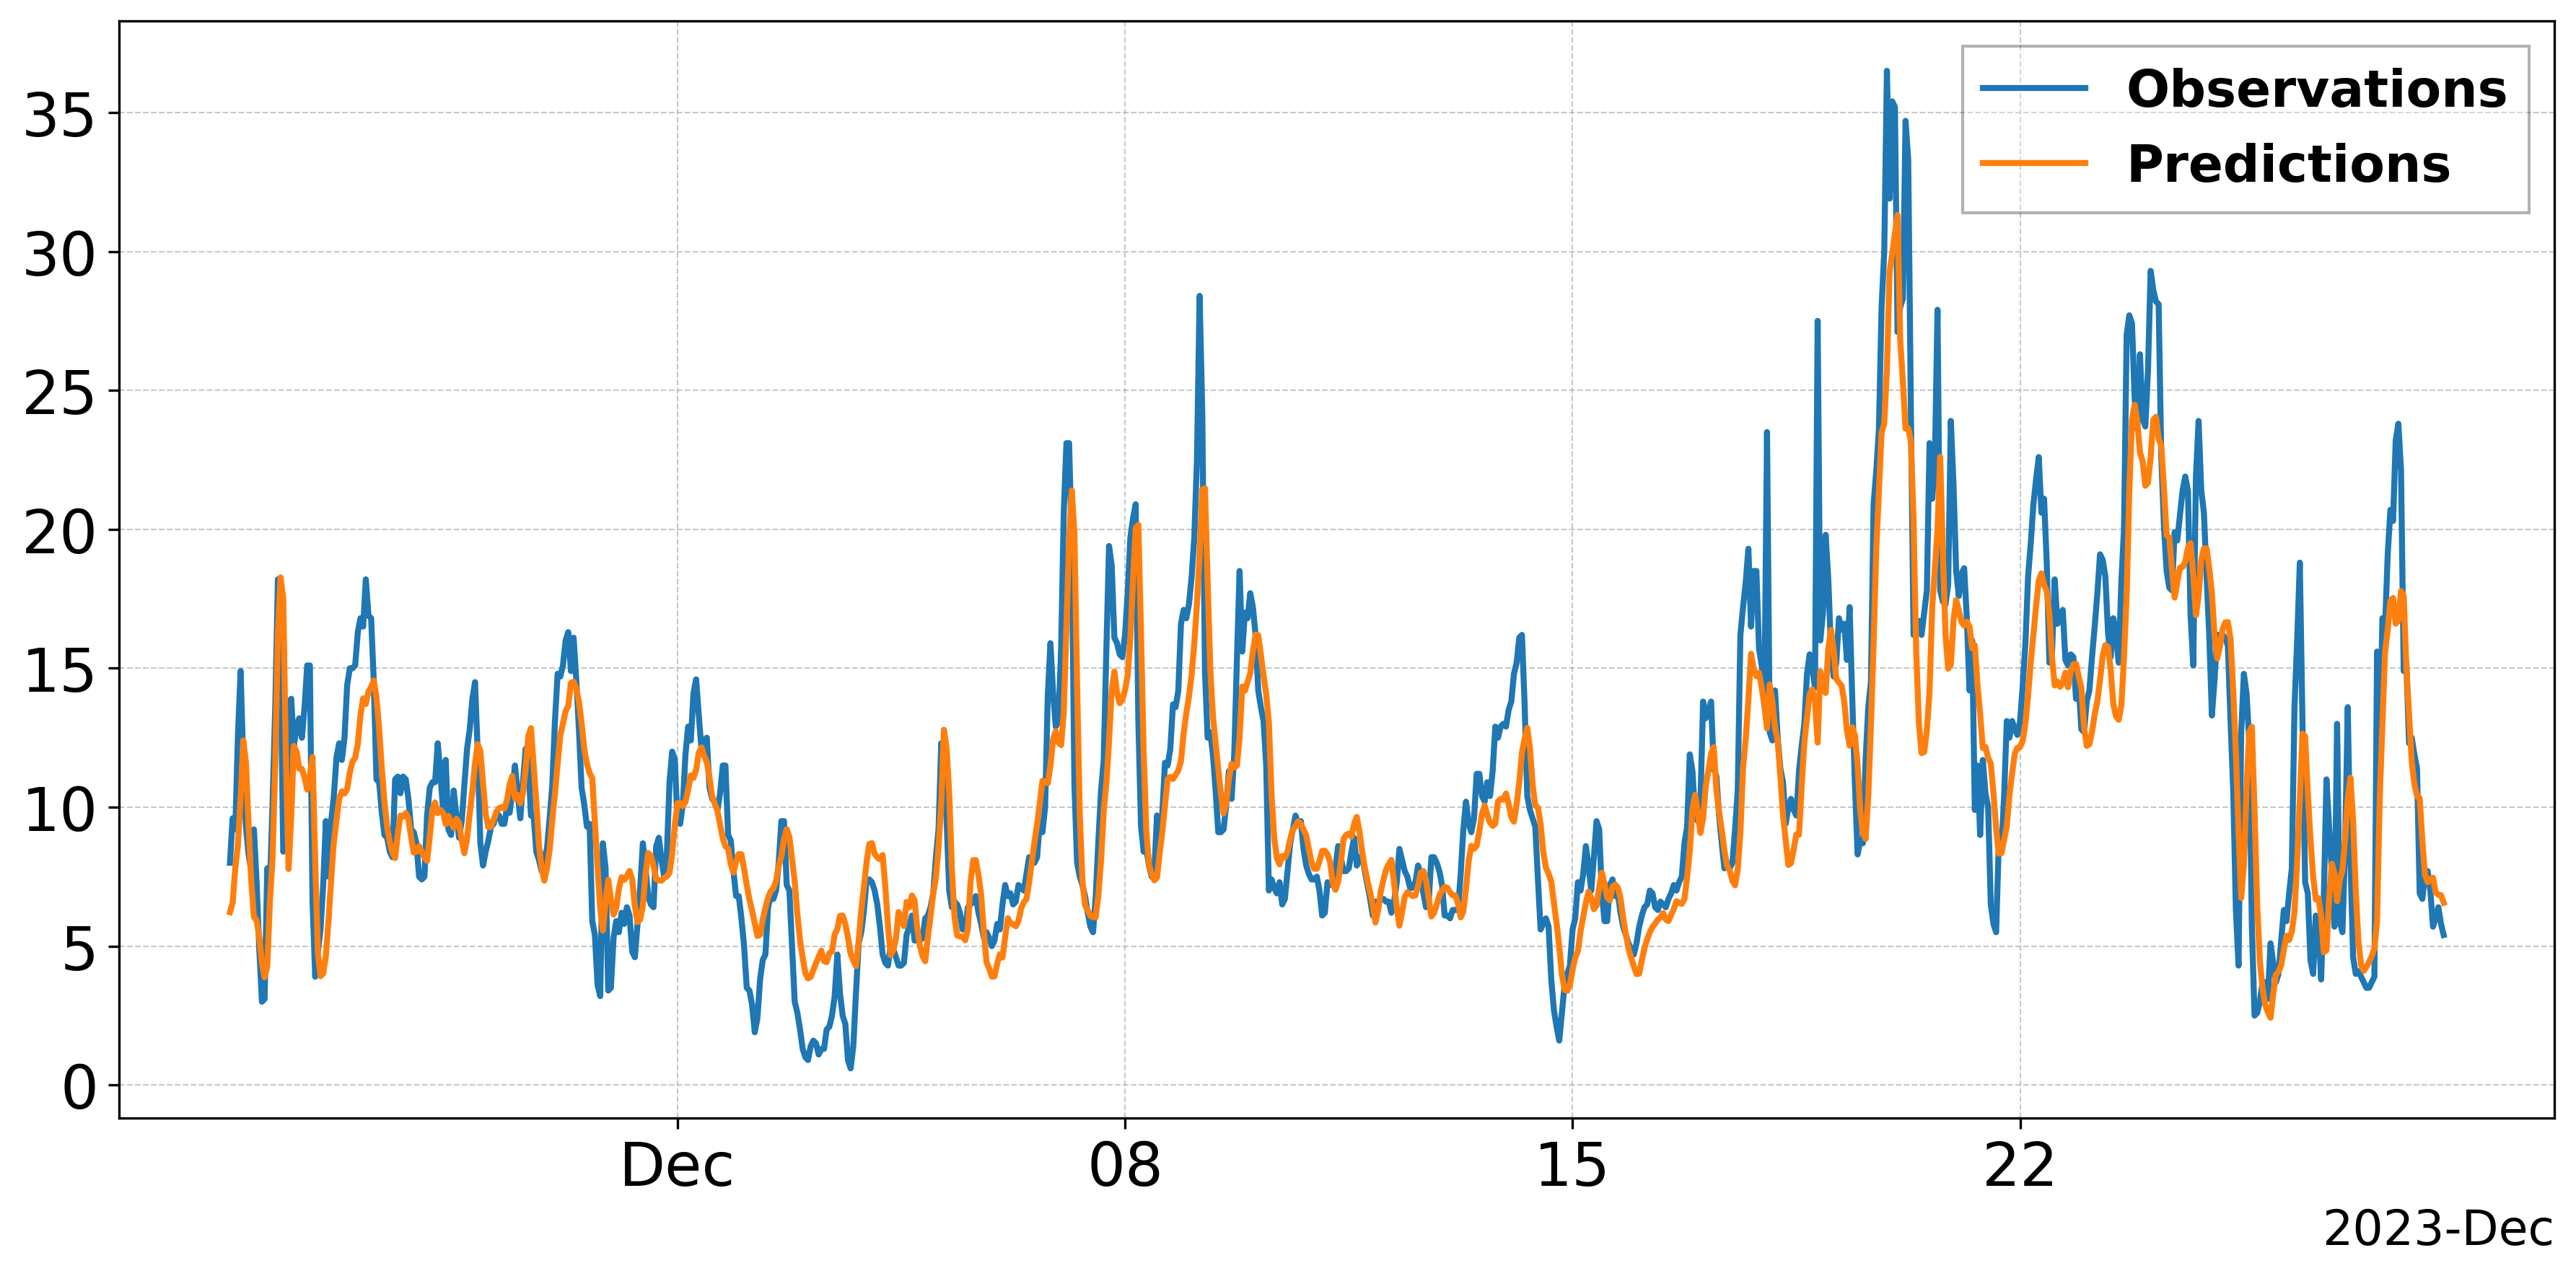

In [42]:
def plot_pred_true(scaled_preds, scaled_labels, r2, mae, rmse):
    # Generate a time range starting from a specific date with hourly frequency
    time = pd.date_range(start='2023-11-24', freq='H', periods=len(scaled_labels))
    
    # Create a high-resolution figure for better quality
    plt.figure(figsize=(12, 6), dpi=300)
    
    # Plot the actual observations
    plt.plot(time, scaled_labels, label='Observations', linewidth=2)
    
    # Plot the model predictions
    plt.plot(time, scaled_preds, label='Predictions', linewidth=2)
    
    # Prepare the text box with evaluation metrics
    textstr = '\n'.join((
        f'RMSE: {rmse:.6f}',
        f'MAE: {mae:.6f}',
        f'R-squared: {r2:.6f}',
    ))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    
    # Get the current Axes instance
    ax = plt.gca()

    # Customize tick parameters for better readability
    ax.tick_params(axis='both', which='major', labelsize=20)
    
    # Add a legend with specific styling
    ax.legend(loc='upper right', frameon=True, fancybox=False, edgecolor='black',
              prop={'weight': 'bold', 'size':17}, framealpha=0.3)
    
    # Configure the x-axis date formatting
    locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    
    # Adjust the font size of the x-axis offset text
    ax.xaxis.get_offset_text().set_fontsize(16)
    
    # Add a grid for easier visualization of data points
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    
    # Adjust the layout to prevent clipping of labels and titles
    plt.tight_layout()
    
    # Save the plot to the specified directory with the model name
    plt.savefig(f'./{args["model_name"]}.png', dpi=300)

def val_model():
    # Initialize the LSTM model with parameters from the args dictionary
    model = LSTM(
        input_size=args['input_size'],       # Number of expected features in the input
        hidden_size=args['hidden_size'],     # Number of features in the hidden state
        num_layers=args['layers'],           # Number of recurrent layers
        dropout=args['dropout'],             # Dropout probability between layers
        output_size=1                        # Output size for regression
    )
    model.to(args['device'])  # Move the model to the specified device (CPU or GPU)
    
    # Load the saved model checkpoint
    checkpoint = torch.load(args['save_file'])
    model.load_state_dict(checkpoint['state_dict'])  # Load the model state
    model.eval()  # Set the model to evaluation mode
    
    preds = []
    labels = []

    # Load and preprocess the data using the get_data function
    labels_max, labels_min, train_loader, val_loader, test_loader = get_data(
        args['corpusFile'], 
        args['sequence_length'], 
        args['batch_size']
    )

    # Disable gradient computation for validation
    with torch.no_grad():
        for idx, (x, label) in enumerate(test_loader):
            x = x.to(args['device'])        # Move inputs to the specified device
            label = label.to(args['device'])# Move targets to the specified device
            pred = model(x)                  # Generate predictions
            preds.extend(pred.cpu().numpy()) # Collect predictions
            labels.extend(label.cpu().numpy())# Collect true labels

    # Convert lists to NumPy arrays and reshape
    preds = np.array(preds).reshape(-1)
    labels = np.array(labels).reshape(-1)

    # Scale the predictions and labels back to original values
    scaled_preds = preds * (labels_max - labels_min) + labels_min
    scaled_labels = labels * (labels_max - labels_min) + labels_min

    # Calculate evaluation metrics
    rmse = np.sqrt(mean_squared_error(scaled_labels, scaled_preds))
    mae = mean_absolute_error(scaled_labels, scaled_preds)
    r_squresd = r2_score(scaled_labels, scaled_preds)
    
    # Print the evaluation metrics
    print(f'RMSE: {rmse:.6f}')
    print(f'MAE: {mae:.6f}')
    print(f'R-squared: {r_squresd:.6f}')

    # Write the evaluation metrics to a text file
    with open(f'evaluation_{args["model_name"]}.txt', 'w', encoding='utf-8') as f:
        f.write(f'RMSE: {rmse:.6f}\n')
        f.write(f'MAE: {mae:.6f}\n')
        f.write(f'R-squared: {r_squresd:.6f}\n')
    
    # Plot the true vs. predicted values
    plot_pred_true(scaled_preds, scaled_labels, r_squresd, mae, rmse)

# Execute the validation function
val_model()


In [ ]:

def create_table(data, title):
    
    df = pd.DataFrame(data).T
    df.reset_index(drop=True, inplace=True)
    df.index += 1 
    df.index.name = 'Index' 
    def wrap_text(text, width):
        return '\n'.join(textwrap.wrap(text, width))

    max_width = 30
    for col in df.columns:
        df[col] = df[col].apply(lambda x: wrap_text(str(x), max_width))


    fig, ax = plt.subplots(figsize=(15, 5), dpi=300)
    ax.set_title(title, fontsize=16, fontweight='bold', color='Black') 
    ax.axis('tight')
    ax.axis('off')

    table = ax.table(cellText=df.values,
                     rowLabels=df.index,
                     colLabels=df.columns,
                     cellLoc='center',
                     loc='center',
                     rowLoc='center',
                     bbox=[0, 0, 1, 1])


    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1)

    num_rows = len(df) + 1 
    num_cols = len(df.columns) + 1  

    for (row, col), cell in table.get_celld().items():
        cell.visible_edges = ''
        if row == 0:
            
            cell.get_text().set_fontweight('bold')
            cell.set_height(0.05)
            cell.visible_edges = 'BT'
            cell.set_edgecolor('black')
            cell.set_linewidth(1)
            cell.get_text().set_color('blue')
            cell.set_facecolor('#d3d3d3')
        elif col == 0:
        
            cell.get_text().set_fontweight('bold')
            
            cell.set_facecolor('#ecf8fd')
        else:

            if row % 2 == 1:
                cell.set_facecolor('#f9f9f9')
            else:
                cell.set_facecolor('#ffffff')

    plt.show()

create_table()